In [29]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import cv2
from util import load_data, preprocess_data
from multi import unet
from simple_multi_unet_model import  jacard_coef  

In [30]:
# Get the list of all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

# Count the number of GPUs
num_gpus = len(physical_devices)

print("Number of available GPUs:", num_gpus)

Number of available GPUs: 1


In [31]:
physical_devices = tf.config.list_physical_devices('GPU')
print('GPU is available' if len(physical_devices) > 0 else 'Not available')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU is available


In [32]:
# initialize input size and shape
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3) # color images, 3 channels

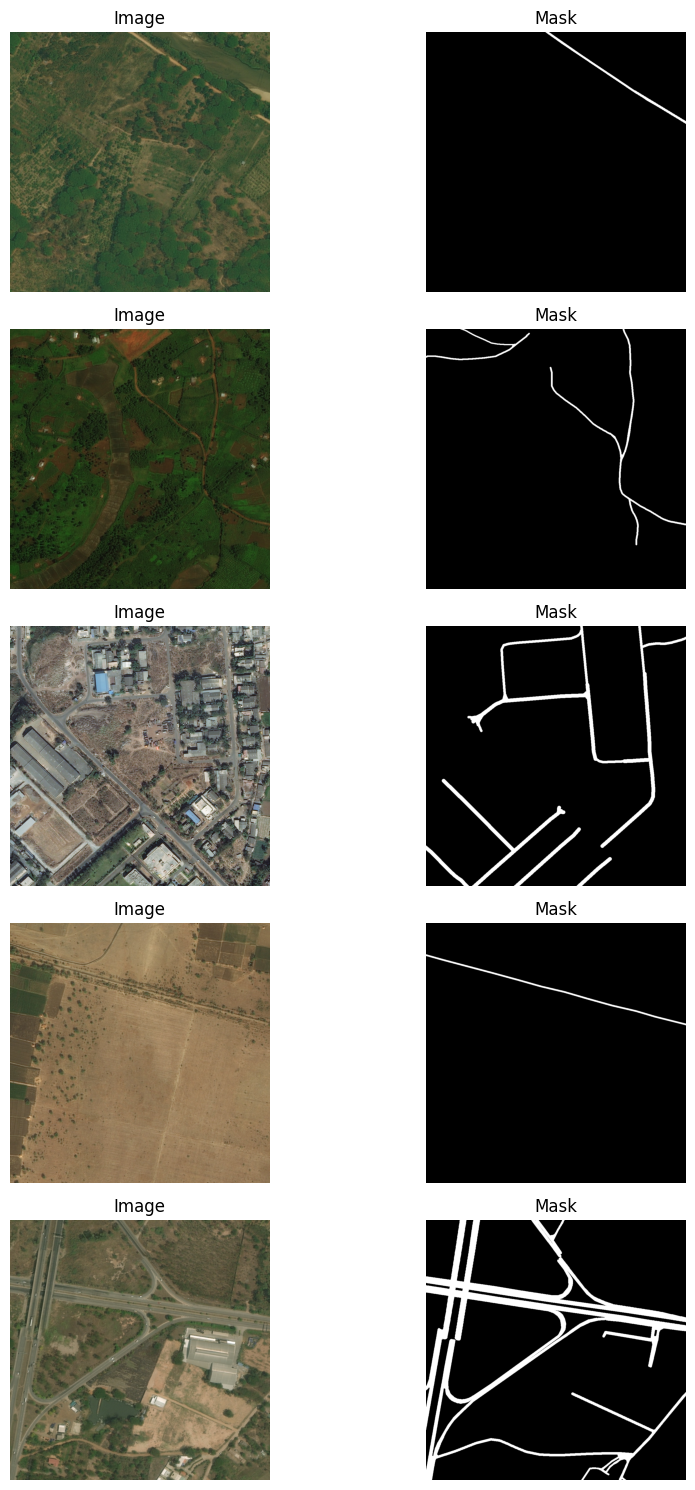

In [33]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import random

def display_data(dir_path, image_paths, mask_paths):

    fig, axes = plt.subplots(5, 2, figsize=(10, 15))

    # Iterate over the image and mask pairs and display them in subplots
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        # Load the image and mask using your preferred method
        image = plt.imread(dir_path + image_path)
        mask = plt.imread(dir_path + mask_path)

        # Plot the image and mask in the corresponding subplot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask)
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.savefig('samples.png', bbox_inches='tight')  # Save as PNG image

    # Show the plot
    plt.show()
    return

# load data
dir_path = 'datasets/'
image_filenames, mask_filenames = load_data(dir_path)

# display the first 5 pairs of image and mask
random_indices = random.sample(range(0, len(image_filenames)), 5)
display_data(dir_path, image_filenames[random_indices], mask_filenames[random_indices])


In [34]:
# preprocess data
with tf.device("/device:GPU:0"):
    # no augmentation due to limited computational resources
    # already have a large amount of data, roughly 12,000 images and masks
    images, masks = preprocess_data(dir_path, image_filenames, mask_filenames, input_size=INPUT_SIZE, augmented=False) 


In [35]:
# get shape
print('Shape of image data: ' + str(images.shape))
print('Shape of mask data: ' + str(masks.shape))

Shape of image data: (129, 256, 256, 3)
Shape of mask data: (129, 256, 256, 1)


In [36]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_images, test_images, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

In [37]:
# save check point
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/save_best.h5', verbose=1, save_best_only=True)

<b>Given that we are predicting a binary mask, the output layer will be designed to accommodate this by having a size of 1.</b>

In [38]:
# Initialize the model
metrics=['accuracy', jacard_coef]
# Initialize the model
model = unet(INPUT_SHAPE, output_layer=1)

In [39]:
# complie the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=metrics)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [41]:
epochs = 1
with tf.device("/GPU:0"):
    history = model.fit(train_images, train_masks, batch_size=8, epochs=epochs, validation_data=(val_images, val_masks), callbacks=[checkpoint])


ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/concatenate_7/concat' defined at (most recent call last):
    File "C:\Users\wafa-\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\wafa-\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\road-extraction-main\venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "D:\road-extraction-main\venv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "D:\road-extraction-main\venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "D:\road-extraction-main\venv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\wafa-\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\wafa-\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\wafa-\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\road-extraction-main\venv\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "D:\road-extraction-main\venv\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "D:\road-extraction-main\venv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "D:\road-extraction-main\venv\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "D:\road-extraction-main\venv\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "D:\road-extraction-main\venv\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "D:\road-extraction-main\venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\road-extraction-main\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "D:\road-extraction-main\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "D:\road-extraction-main\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\road-extraction-main\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\road-extraction-main\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\road-extraction-main\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\wafa-\AppData\Local\Temp\ipykernel_3524\1039305794.py", line 3, in <module>
      history = model.fit(train_images, train_masks, batch_size=8, epochs=epochs, validation_data=(val_images, val_masks), callbacks=[checkpoint])
    File "D:\road-extraction-main\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\road-extraction-main\venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\layers\merging\base_merge.py", line 196, in call
      return self._merge_function(inputs)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\layers\merging\concatenate.py", line 134, in _merge_function
      return backend.concatenate(inputs, axis=self.axis)
    File "D:\road-extraction-main\venv\lib\site-packages\keras\backend.py", line 3572, in concatenate
      return tf.concat([to_dense(x) for x in tensors], axis)
Node: 'model_1/concatenate_7/concat'
OOM when allocating tensor with shape[8,32,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/concatenate_7/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6824]

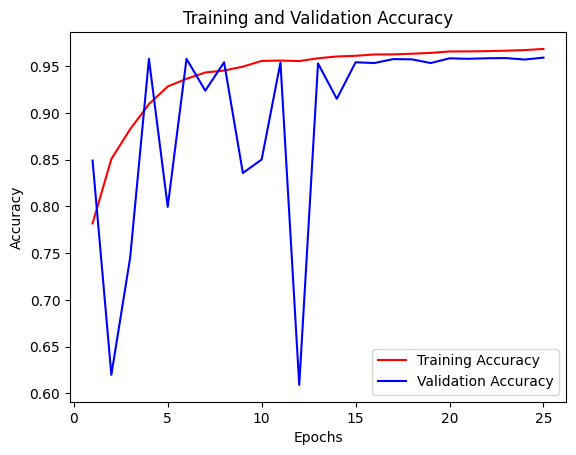

In [15]:
# Accessing training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, epochs + 1)

# Plotting
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
model.save('models/multi.h5')

In [17]:
eval = model.evaluate(test_images, test_masks)
print('Test accuracy: ' + "{:.2f}".format(eval[1]))

2/2 [==============================] - 7s 6s/step - loss: 0.1483 - accuracy: 0.9604
Test accuracy: 0.96


In [23]:
from tensorflow.keras.models import load_model
# load the saved model due to prior interuption
model = load_model('models/multi.h5')

1/1 [==============================] - 1s 671ms/step


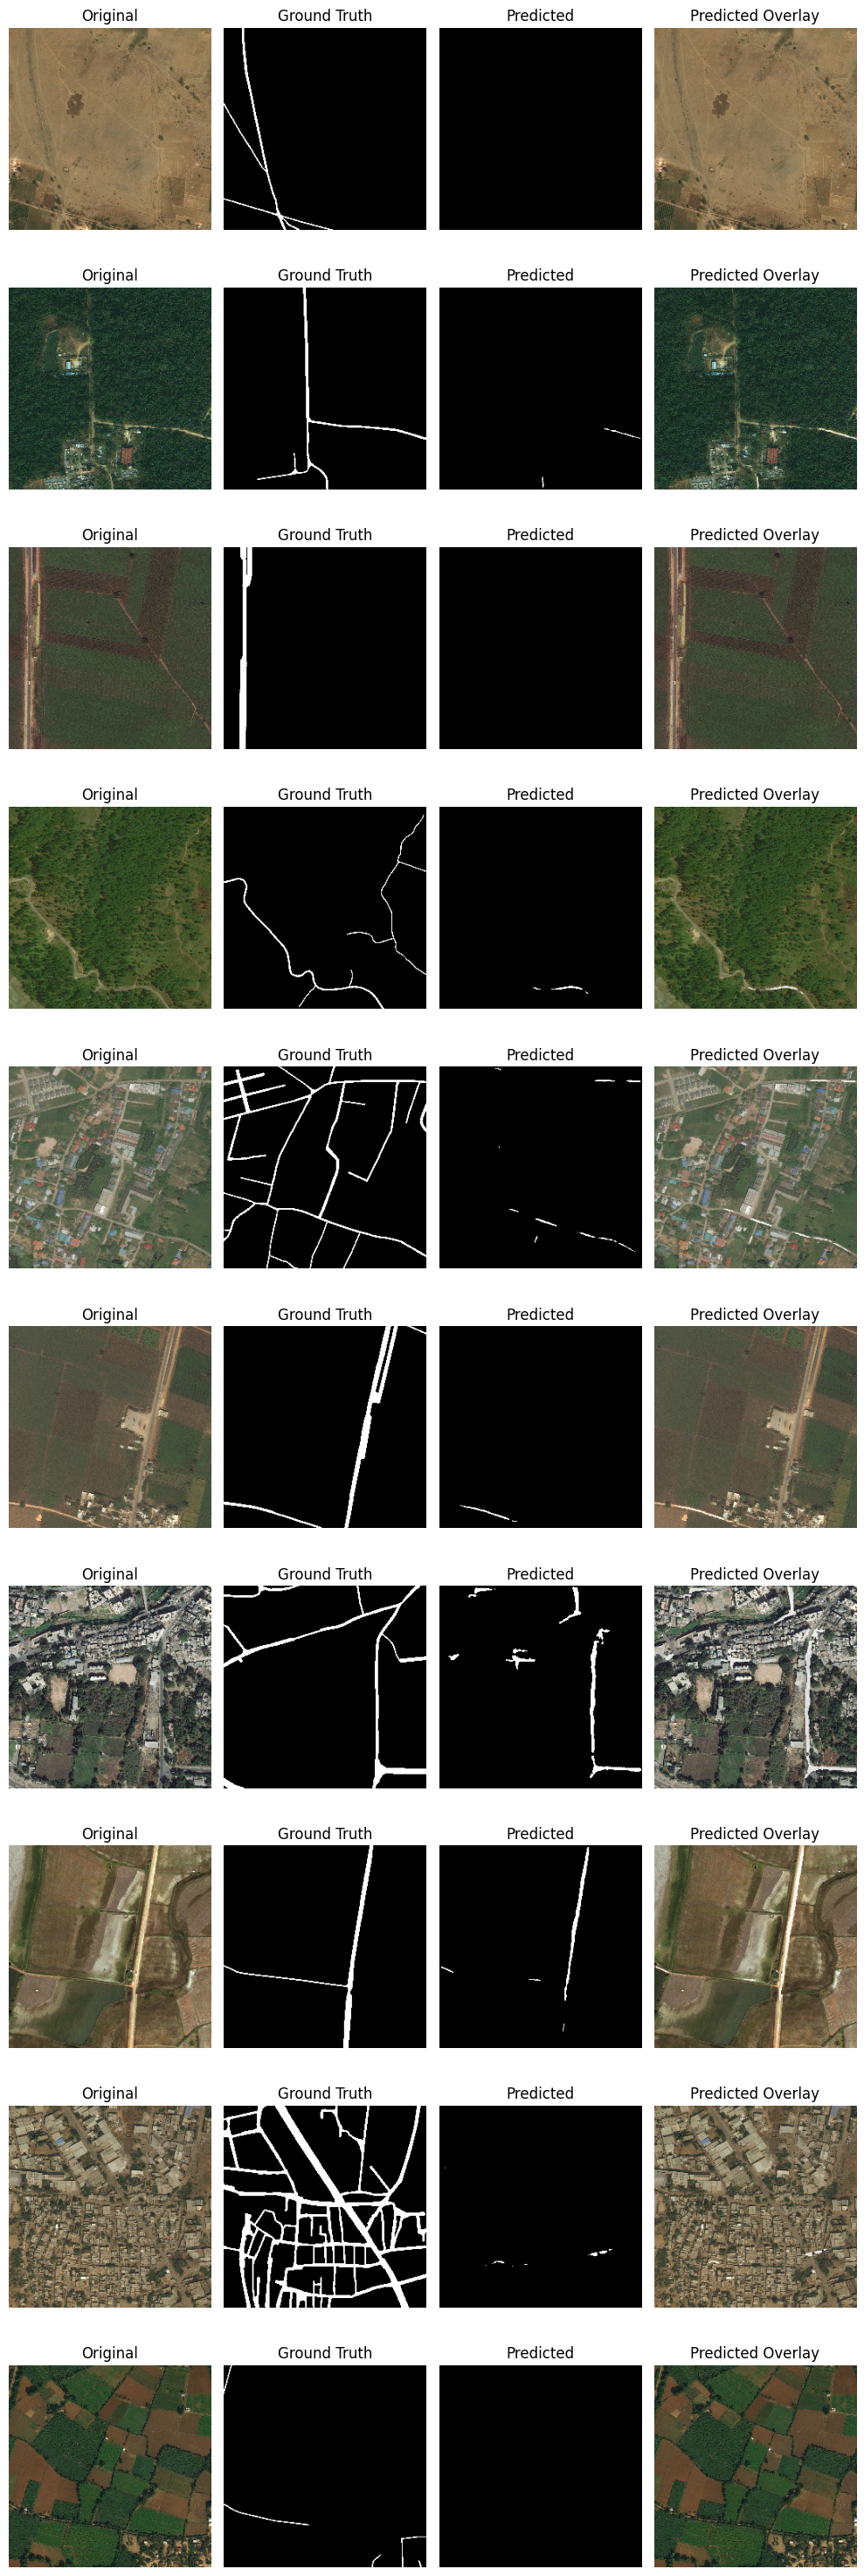

In [24]:
# display 10 random predictions
random_indices = random.sample(range(0, len(test_images)), 10)
test_sample = test_images[random_indices]

predictions = model.predict(test_sample)
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(10, 4, figsize=(10, 3*10))

# Iterate over the image and mask pairs and display them in subplots
for i in range(len(test_sample)):

    image = (test_sample[i] * 255).astype(np.uint8)
    mask = predictions[i]
    ground_truth = test_masks[random_indices][i] * np.array([255, 255, 255]) # convert the forground into yellow color to achieve the desired aesthetic

    overlay = image.copy()

    mask = np.repeat(mask, 3, axis=2) # matching the size of the channel of the mask and the image to perform an overlay
    inverted_mask = 1 - mask

    yellow_mask = np.array([255, 255, 255]) * mask

    # Apply the mask on the image
    result = image * inverted_mask + yellow_mask
    alpha = 0.2
    predicted_overlay = cv2.addWeighted(overlay, alpha, result.astype(overlay.dtype), 1 - alpha, 0)

    # Plot the image and mask in the corresponding subplot
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(ground_truth)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(yellow_mask)
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(predicted_overlay)
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')
    
# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('result.png', bbox_inches='tight')  # Save as PNG image

# Show the plot
plt.show()
# save the output



1/1 [==============================] - 0s 35ms/step


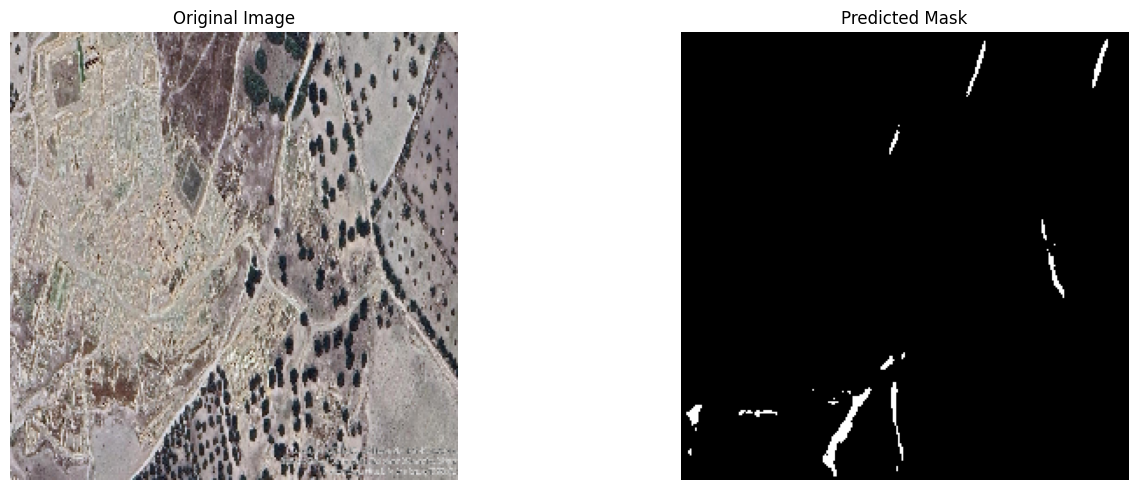

In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    """Load and preprocess the input image."""
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

def predict_image(model, image_path):
    """Predict the mask for the input image using the pre-trained model."""
    input_image = load_and_preprocess_image(image_path)
    prediction = model.predict(input_image)
    prediction = (prediction > 0.5).astype(np.uint8)  # Thresholding the prediction
    return input_image[0], prediction[0]

def visualize_results(image, mask, overlay_alpha=0.2):
    """Visualize the original image, predicted mask, and overlay."""
    image = (image * 255).astype(np.uint8)
    mask = np.repeat(mask, 3, axis=2) * np.array([255, 255, 255])  # Convert to white mask
    
    inverted_mask = 1 - mask
    result = image * inverted_mask + mask

    overlay = image.copy()
    predicted_overlay = cv2.addWeighted(overlay, overlay_alpha, result.astype(overlay.dtype), 1 - overlay_alpha, 0)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask.astype(np.uint8))
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')


    plt.tight_layout()
    plt.show()

# Path to your own input image
input_image_path = 'Arch of Septimus Severus.jpg'

# Predict and visualize the results
original_image, predicted_mask = predict_image(model, input_image_path)
visualize_results(original_image, predicted_mask)